In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [17]:
# target top 5 sustance
substance_colors = {
    "Fluoranthene": "plum",
    "Copper": "pink",
    "Indeno(1,2,3-cd)pyrene": "moccasin",
    "Benzo(a)pyrene": "lightgreen",
    "Cypermethrin": "lightskyblue",
}
target_substances = list(substance_colors.keys())

pnec_values = {
    "Indeno(1,2,3-cd)pyrene": 0.00017,
    "Benzo(a)pyrene": 0.00017,  
    "Cypermethrin": 3e-05,
    "Fluoranthene": 0.000762,
    "Copper": 1.0,
}

data_files = {
    2016: "Dataset_v4/d16_v4.csv",
    2017: "Dataset_v4/d17_v4.csv",
    2018: "Dataset_v4/d18_v4.csv",
    2019: "Dataset_v4/d19_v4.csv",
    2020: "Dataset_v4/d20_v4.csv",
    2021: "Dataset_v4/d21_v4.csv",
    2022: "Dataset_v4/d22_v4.csv",
    2023: "Dataset_v4/d23_v4.csv",
}

all_data = []

# load and process the data
for year, path in data_files.items():
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()
    df["REGION"] = df["REGION"].str.strip()
    
    df = df[
        df["SUBSTANCE NAME"].isin(target_substances) &
        df["REGION"].notna() &
        df["REPORTING THRESHOLD (kg)"].notna() &
        df["QUANTITY RELEASED (kg)"].notna()
    ].copy()

    df["Year"] = year
    all_data.append(df)

# Merge the data
df_all = pd.concat(all_data, ignore_index=True)

### The quantity releasing of each substance in each Region

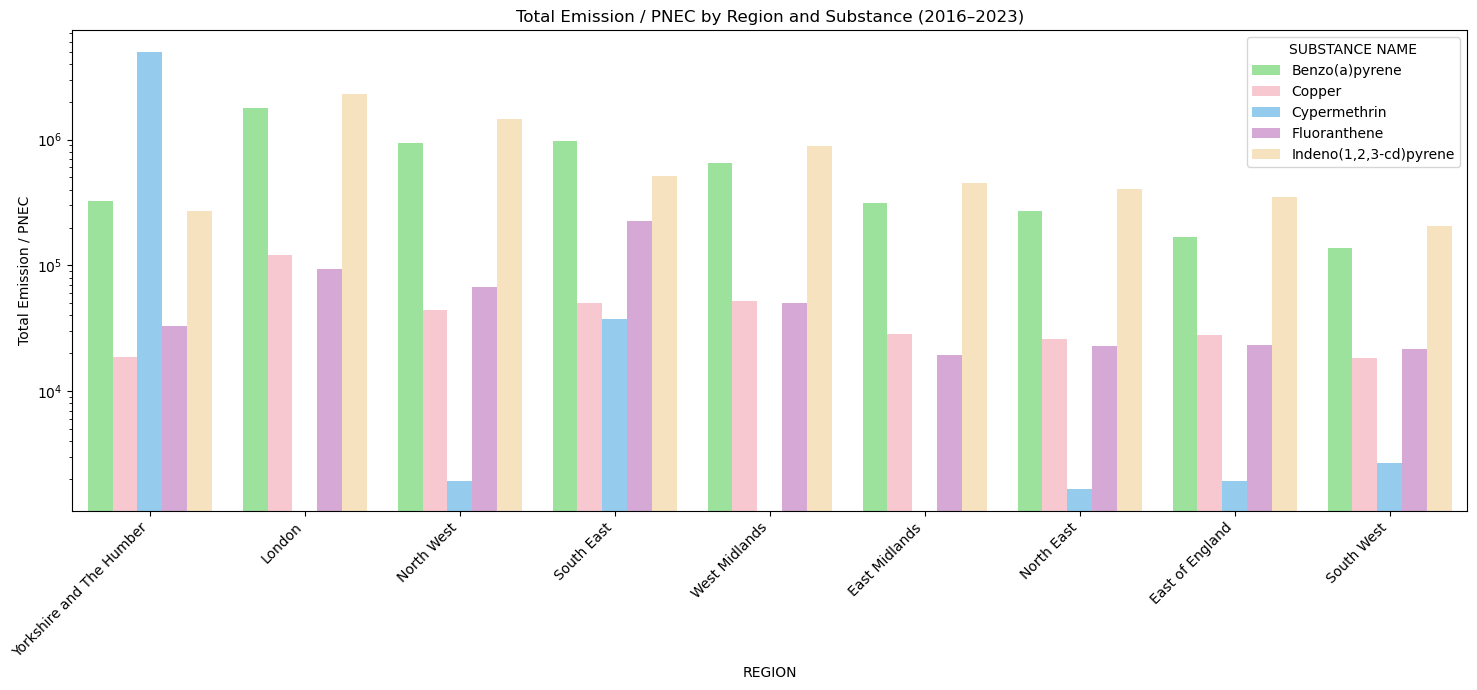

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# PNEC 值
pnec_values = {
    "Indeno(1,2,3-cd)pyrene": 0.00017,
    "Benzo(a)pyrene": 0.00017,  
    "Cypermethrin": 3e-05,
    "Fluoranthene": 0.000762,
    "Copper": 1.0,
}

# 分组汇总排放量
grouped_bar = (
    df_all.groupby(["REGION", "SUBSTANCE NAME"])["QUANTITY RELEASED (kg)"]
    .sum()
    .reset_index()
)

# 添加 PNEC 和 归一化排放指标
grouped_bar["PNEC"] = grouped_bar["SUBSTANCE NAME"].map(pnec_values)
grouped_bar["NORMALIZED EMISSION"] = grouped_bar["QUANTITY RELEASED (kg)"] / grouped_bar["PNEC"]

# ✅ 重新按 NORMALIZED EMISSION 总量对 REGION 排序
region_severity = grouped_bar.groupby("REGION")["NORMALIZED EMISSION"].sum().sort_values(ascending=False)
sorted_regions = region_severity.index.tolist()

# 绘图
plt.figure(figsize=(15, 7))
sns.barplot(
    data=grouped_bar,
    x="REGION",
    y="NORMALIZED EMISSION",
    hue="SUBSTANCE NAME",
    order=sorted_regions,
    palette=substance_colors
)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Total Emission / PNEC by Region and Substance (2016–2023)")
plt.ylabel("Total Emission / PNEC")
plt.tight_layout()
plt.savefig("RegionAnalysis/region_substance_grouped_bar_sorted_by_normalized.png", dpi=300)
plt.show()


### Filter the most polluted regions （According to PNEC）

In [6]:
import pandas as pd

# PNEC value
pnec_values = {
    "Indeno(1,2,3-cd)pyrene": 0.00017,
    "Benzo(a)pyrene": 0.00017,  
    "Cypermethrin": 3e-05,
    "Fluoranthene": 0.000762,
    "Copper": 1.0,
}

csv_paths = [
    "Dataset_v4/d16_v4.csv",
    "Dataset_v4/d17_v4.csv",
    "Dataset_v4/d18_v4.csv",
    "Dataset_v4/d19_v4.csv",
    "Dataset_v4/d20_v4.csv",
    "Dataset_v4/d21_v4.csv",
    "Dataset_v4/d22_v4.csv",
    "Dataset_v4/d23_v4.csv",
]

dfs = []
for path in csv_paths:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["SUBSTANCE NAME"] = df["SUBSTANCE NAME"].str.strip()
    df["Year"] = int(path.split("/d")[1].split("_")[0]) + 2000  
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)

# filter the data
target_substances = list(pnec_values.keys())
df_filtered = all_data[
    all_data["SUBSTANCE NAME"].isin(target_substances) &
    all_data["Latitude"].notna() &
    all_data["Longitude"].notna() &
    all_data["REPORTING THRESHOLD (kg)"].notna() &
    all_data["QUANTITY RELEASED (kg)"].notna() &
    all_data["REGION"].notna()
].copy()

df_filtered["PNEC"] = df_filtered["SUBSTANCE NAME"].map(pnec_values)
df_filtered["PNEC_SCORE"] = df_filtered["QUANTITY RELEASED (kg)"] / df_filtered["PNEC"]

# Aggregate the pollution intensity by Region
region_severity = df_filtered.groupby("REGION")["PNEC_SCORE"].sum().reset_index()
region_severity = region_severity.sort_values("PNEC_SCORE", ascending=False).reset_index(drop=True)
region_severity.rename(columns={"PNEC_SCORE": "Total PNEC-Normalized Emission"}, inplace=True)

print("\n Region Pollution Severity Ranking (Based on PNEC):")
print(region_severity.to_string(index=False))



 Region Pollution Severity Ranking (Based on PNEC):
                  REGION  Total PNEC-Normalized Emission
Yorkshire and The Humber                    5.591759e+06
                  London                    4.264943e+06
              North West                    2.503730e+06
              South East                    1.795308e+06
           West Midlands                    1.646293e+06
           East Midlands                    8.100235e+05
              North East                    7.263153e+05
         East of England                    5.719854e+05
              South West                    3.871634e+05


### Filter the most polluted counties （According to PNEC）

In [7]:
# Aggregate the pollution intensity by Region
county_severity = df_filtered.groupby("COUNTY")["PNEC_SCORE"].sum().reset_index()

county_severity.rename(columns={"PNEC_SCORE": "Total PNEC-Normalized Emission"}, inplace=True)

# Sort by severity in descending order
county_severity = county_severity.sort_values("Total PNEC-Normalized Emission", ascending=False).reset_index(drop=True)

print("\n County Pollution Severity Ranking (Based on PNEC):")
print(county_severity.to_string(index=False))



 County Pollution Severity Ranking (Based on PNEC):
                             COUNTY  Total PNEC-Normalized Emission
                          Wakefield                    2.262036e+06
                           Kirklees                    2.166916e+06
                             Newham                    1.859759e+06
                               Kent                    1.042539e+06
                         Birmingham                    8.654487e+05
                             Bexley                    8.357229e+05
                           Hounslow                    7.947897e+05
                 North Lincolnshire                    6.165091e+05
                           Trafford                    5.615019e+05
                           Bradford                    5.260804e+05
                         Lancashire                    5.004387e+05
                          Hampshire                    4.519312e+05
                     North Tyneside                    4.495235

### F-test for regions


 F-test (ANOVA) Result 
F-statistic: 17.0896
P-value    : 1.7787e-25
 There is a statistically significant difference between regions (p < 0.05)


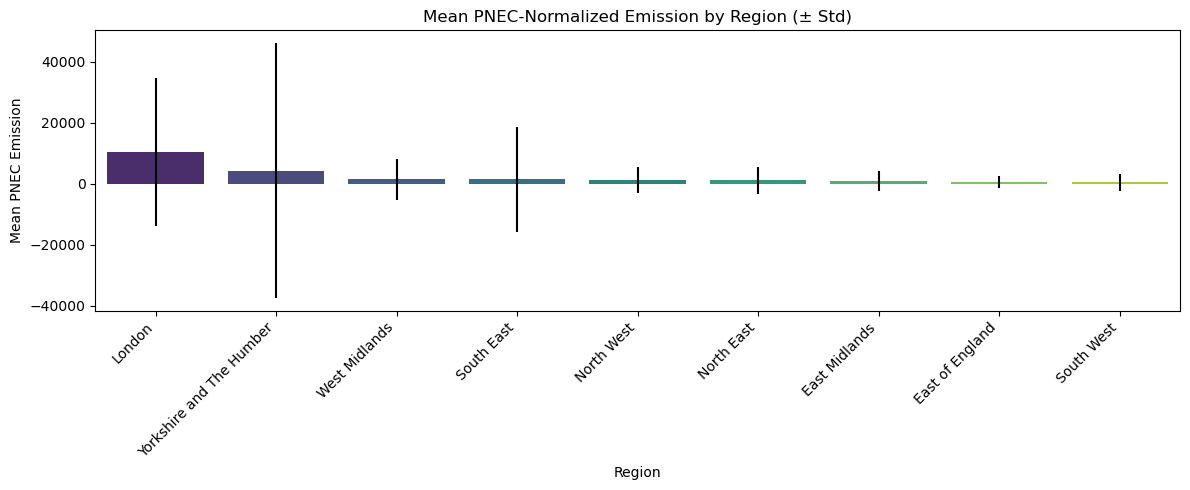

In [8]:
import seaborn as sns
from scipy.stats import f_oneway
pnec_values = {
    "Indeno(1,2,3-cd)pyrene": 0.00017,
    "Benzo(a)pyrene": 0.00017,
    "Cypermethrin": 3e-05,
    "Fluoranthene": 0.000762,
    "Copper": 1.0
}

df_all["PNEC_SCORE"] = df_all.apply(
    lambda row: row["QUANTITY RELEASED (kg)"] / pnec_values.get(row["SUBSTANCE NAME"], np.nan),
    axis=1
)


# Only retain the valid data of PNEC_SCORE
df_valid = df_all.dropna(subset=["PNEC_SCORE", "REGION", "SUBSTANCE NAME"])

# Grouping: The PNEC_SCORE list of all regions
region_groups = [
    group["PNEC_SCORE"].values
    for _, group in df_valid.groupby("REGION")
    if len(group["PNEC_SCORE"]) >= 2 
]

# get the regions' names
region_names = [
    name for name, group in df_valid.groupby("REGION")
    if len(group["PNEC_SCORE"]) >= 2
]

# F-test 
f_stat, p_val = f_oneway(*region_groups)

print("\n F-test (ANOVA) Result ")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value    : {p_val:.4e}")
if p_val < 0.05:
    print(" There is a statistically significant difference between regions (p < 0.05)")
else:
    print(" No statistically significant difference found (p >= 0.05)")


# Visualization: Mean bar chart ± standard deviation
plt.figure(figsize=(12, 5))
region_stats = df_valid.groupby("REGION")["PNEC_SCORE"].agg(["mean", "std"]).sort_values("mean", ascending=False)
sns.barplot(x=region_stats.index, y=region_stats["mean"], yerr=region_stats["std"], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Mean PNEC-Normalized Emission by Region (± Std)")
plt.ylabel("Mean PNEC Emission")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


### F-test for Years


 F-test (ANOVA) Result 
F-statistic: 0.6845
P-value    : 6.8536e-01
 No statistically significant difference found (p >= 0.05)


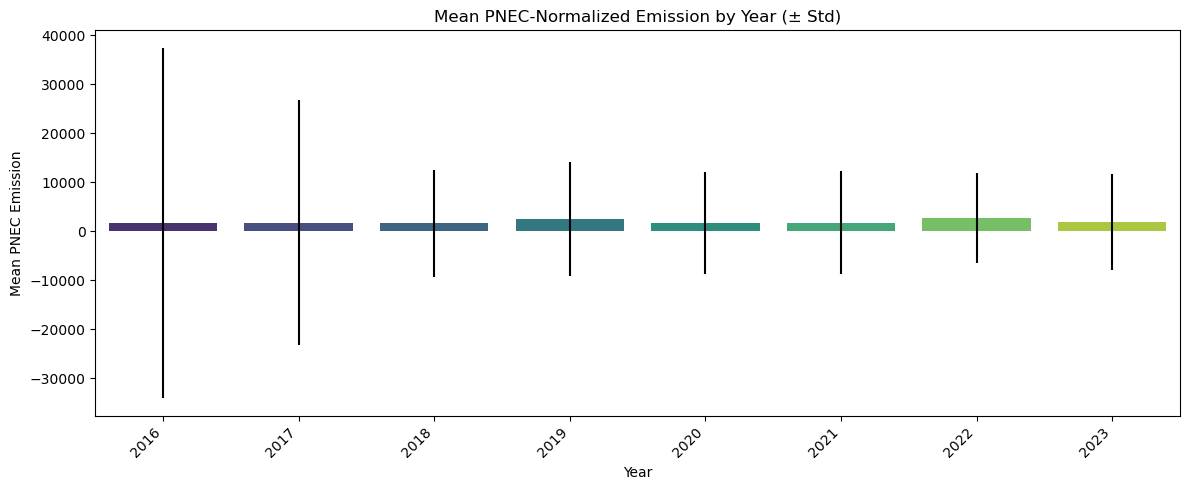

In [9]:
# Only retain the valid data of PNEC_SCORE
df_valid = df_all.dropna(subset=["PNEC_SCORE", "Year", "SUBSTANCE NAME"])

# Grouping: The PNEC_SCORE list of all years
region_groups = [
    group["PNEC_SCORE"].values
    for _, group in df_valid.groupby("Year")
    if len(group["PNEC_SCORE"]) >= 2 
]

# get the years
region_names = [
    name for name, group in df_valid.groupby("Year")
    if len(group["PNEC_SCORE"]) >= 2
]

# F-test 
f_stat, p_val = f_oneway(*region_groups)

print("\n F-test (ANOVA) Result ")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value    : {p_val:.4e}")
if p_val < 0.05:
    print(" There is a statistically significant difference between regions (p < 0.05)")
else:
    print(" No statistically significant difference found (p >= 0.05)")


# Visualization: Mean bar chart ± standard deviation
plt.figure(figsize=(12, 5))
region_stats = df_valid.groupby("Year")["PNEC_SCORE"].agg(["mean", "std"]).sort_values("mean", ascending=False)
sns.barplot(x=region_stats.index, y=region_stats["mean"], yerr=region_stats["std"], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Mean PNEC-Normalized Emission by Year (± Std)")
plt.ylabel("Mean PNEC Emission")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


### The most polluted regions for each substance

In [10]:
df_valid = df_all.dropna(subset=["SUBSTANCE NAME", "REGION", "PNEC_SCORE"])

# Group by SUBSTANCE NAME and Region, and calculate the total PNEC-normalized emissions
grouped = df_valid.groupby(["SUBSTANCE NAME", "REGION"])["PNEC_SCORE"].sum().reset_index()

# For each substance, find the Region with the largest PNEC_SCORE (the most polluted).
worst_pollution_regions = grouped.loc[grouped.groupby("SUBSTANCE NAME")["PNEC_SCORE"].idxmax()].reset_index(drop=True)

worst_pollution_regions.columns = ["Substance", "Worst Region", "Total PNEC-Normalized Emission"]

# sort
worst_pollution_regions = worst_pollution_regions.sort_values(by="Total PNEC-Normalized Emission", ascending=False)

print("\n Region with the Most Severe PNEC-Normalized Pollution for Each Substance:")
print(worst_pollution_regions.to_string(index=False))



 Region with the Most Severe PNEC-Normalized Pollution for Each Substance:
             Substance             Worst Region  Total PNEC-Normalized Emission
          Cypermethrin Yorkshire and The Humber                    4.947727e+06
Indeno(1,2,3-cd)pyrene                   London                    2.282553e+06
        Benzo(a)pyrene                   London                    1.767151e+06
          Fluoranthene               South East                    2.243162e+05
                Copper                   London                    1.209698e+05


### The most polluted substances for each regions

In [11]:
df_valid = df_all.dropna(subset=["REGION", "SUBSTANCE NAME", "PNEC_SCORE"])

# Group by SUBSTANCE NAME and Region, and calculate the total PNEC-normalized emissions
grouped = df_valid.groupby(["REGION", "SUBSTANCE NAME"])["PNEC_SCORE"].sum().reset_index()

# For each substance, find the Region with the largest PNEC_SCORE (the most polluted).
worst_pollution_regions = grouped.loc[grouped.groupby("REGION")["PNEC_SCORE"].idxmax()].reset_index(drop=True)

worst_pollution_regions.columns = ["Region", "Most Substancde", "Total PNEC-Normalized Emission"]

# sort
worst_pollution_regions = worst_pollution_regions.sort_values(by="Total PNEC-Normalized Emission", ascending=False)

print("\n Substance with the Most Severe PNEC-Normalized Pollution for Each Region:")
print(worst_pollution_regions.to_string(index=False))



 Substance with the Most Severe PNEC-Normalized Pollution for Each Region:
                  Region        Most Substancde  Total PNEC-Normalized Emission
Yorkshire and The Humber           Cypermethrin                    4.947727e+06
                  London Indeno(1,2,3-cd)pyrene                    2.282553e+06
              North West Indeno(1,2,3-cd)pyrene                    1.458412e+06
              South East         Benzo(a)pyrene                    9.681588e+05
           West Midlands Indeno(1,2,3-cd)pyrene                    8.860429e+05
           East Midlands Indeno(1,2,3-cd)pyrene                    4.507647e+05
              North East Indeno(1,2,3-cd)pyrene                    4.048235e+05
         East of England Indeno(1,2,3-cd)pyrene                    3.498347e+05
              South West Indeno(1,2,3-cd)pyrene                    2.074706e+05
